# LLM Zoomcamp - Week 3 Notes

In this section the focus is on the following:
- Applying Vector Databases as an alternative to Elasticsearch in the previous two models.
    - Important to note that Elasticsearch has the ability to operate as a Vector DB as an alternative to Lucene and will be covered as well
- Vector embeddings and their role in building RAG applications
- Evaluation methods for search / query retrieval performance

## 3.1 Introduction to Vector Search
- Vector search has been around for a while and is getting popular again largely because LLMs lack long-term memory and have limited context windows
    - Vector DBs are an economical and effective way to store data for use with LLMs
- Elastic.co does a good job of explaining what vector embeddings are [here](https://www.elastic.co/what-is/vector-embedding)
    - Here's their definition:
    - ```Vector embeddings are a way to convert words and sentences and other data into numbers that capture their meaning and relationships. They represent different data types as points in a multidimensional space, where similar data points are clustered closer together. These numerical representations help machines understand and process this data more effectively.```
- Vector databases are databases that index and store vector embeddings
    - Which means you can easily store them, reference them, compare different vectors semantically (using various distance measures, etc.)
- Here's what it would look like when put together with an LLM:
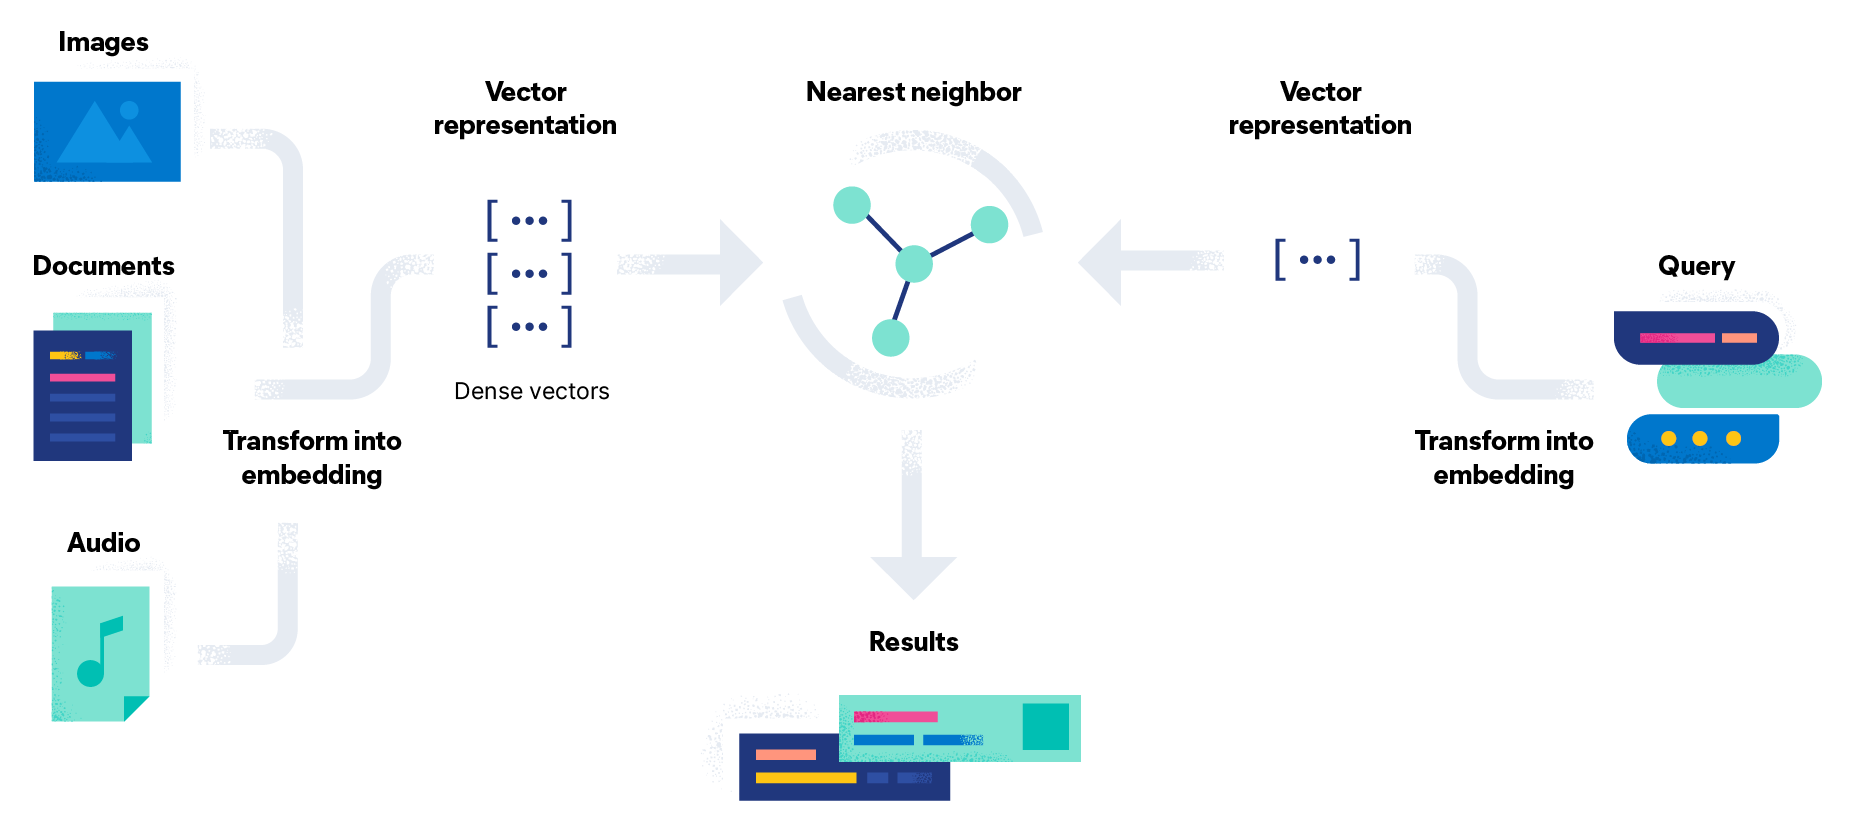

## 3.2 How to do Vectorized Search with Elasticsearch
- Let's start with the architecture of the Semantic Search system we're going to build:
```mermaid
graph LR
    documents.json -->|load| documents
    subgraph Process
        documents --> embeddings
        embeddings --> index
        index -->|store| Elasticsearch[(Elasticsearch vector DB)]
    end
    Elasticsearch -->|retrieve| Semantic_search_results(Semantic search results)
    new_search_query(New search query) -.-> embeddings
    embeddings  -.-> Elasticsearch
	
	style new_search_query stroke:blue,stroke-width:2px;
```

- The way this system works is as follows:
    - our `documents.json` file is converted into an Elasticsearch `documents` object which is then vectorized into `embeddings`
    - Those vector embeddings are the things we convert into another Elasticsearch concept called an `index`
        - We already used indexes in the previous sections
    - The `embeddings` and the `index` are what are stored in our vector database
    - And when a user passes a query, that query is first vectorized into an embedding and compared against the existing embeddings in order to produce a search result

- Let's implement this thing!

### 3.2.1 Let's start with Semantic Search

#### Step 1 - Load our documents

In [4]:
import requests

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

# write documents to a json file
import json
with open('documents.json', 'w') as f:
    json.dump(documents, f, indent=2)


`documents_raw` is a list having the course and the data corresponding to that course 

#### Step 2 - Create embeddings using pre-trained models
- We're going to use the `sentence_transformers` library to access pre-trained embedding models
    - You can learn more about that here: https://sbert.net/
- Before going into the rest of the tutorial, I asked ChatGPT to explain what this library does in simple terms. It's basically a library with various sentence embedding models you can use to create sentence embeddings with transformer-based models
- Here's an example of how it's used when wanting to compare sentence similarity:

In [6]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained model
model = SentenceTransformer('all-mpnet-base-v2')

# Encode sentences to get embeddings
sentences = ["How are you?", "What is your name?", "Hello! How do you do?"]
embeddings = model.encode(sentences)

# Compute similarity between the first sentence and the others
similarities = util.pytorch_cos_sim(embeddings[0], embeddings[1:])

print(similarities)


tensor([[0.3600, 0.6323]])


- This is computing cosine similarity betwen the first word `embeddings[0]` and the other 2 words `embeddings[1:]`
    - It's telling us the 3rd sentence is almost 2x more similar to the first sentence than the second
- Intuitively, this makes sense!
- Ok, let's forge ahead and see how we apply this to our FAQ document
    - Let's create embeddings out of the `'text'` field in the documents list

In [19]:
documents_embedding = []

for doc in documents:
    doc['text_embedding'] = model.encode(doc['text']).tolist()
    documents_embedding.append(doc)

documents_embedding[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'text_embedding': [-0.03570355847477913,
  -0.06891412287950516,
  -0.044483352452516556,
  0.0062501393258571625,
  -0.042247142642736435,
  -0.006454026326537132,
  0.02754812128841877,
  -0.018610356375575066,
  -0.052037592977285385,
  -0.0024046804755926132,
  0.057454537600278854,
  -0.015592586249113083,
  0.015488773584365845,
  0.09870164841413498,
  0.01564964279532432

#### Step 3 - Set up Elasticsearch connection

In [22]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://192.168.50.49:9200')

es_client.info()

ObjectApiResponse({'name': 'b3a351c3296c', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'OJZEGlS9RR6yoR11cShgug', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4 Create Elasticsearch mappings and index
- The mapping is some metadata telling Elasticsearch how the fields and content in the documents should be typed
    - Each document in the is a collection of fields, each having a different data type
    - And we've now added a new one, which is the embedding of the `text` field
- This is similar to setting a database schema
- We are just going to take the `index_settings` from week 1 and add the embedding
- When adding the new embeddings field to the `properties` section, we are specifying a type `dense_vector` in addition to some other parameters:
    - A `dense vector` is a type of vector used to represent data in high-dimensional space and each element of the is stored and non-zero (contrast to a sparse vector)
    - The `dims` are just the dimension of the vector which can be found by finding the length of the encoding `len(encoded_field)`
        - Different models you choose will create vectors of the varying dimensions, but the same model will create vectors of the same length
    - Specifying `index:True` just lets us efficiently store and query it
    - And lastly setting `similarities` to `cosine` will just allow us to efficiently calculate cosine similarity between different fields efficiently

In [24]:
len(documents_embedding[4]['text_embedding'])

768

In [27]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "text_embedding": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"}
        }
    }
}

index_name = "course-questions"

if es_client.indices.exists(index=index_name):
    es_client.indices.delete(index=index_name)
    print(f"Index {index_name} deleted.")
else:
    print(f"Index {index_name} does not exist.")
    es_client.indices.create(index=index_name, body=index_settings)

Index course-questions does not exist.


#### Step 5 Add documents to the index
- I'm just pulling the same code from the previous weeks to do this

In [29]:
from tqdm.auto import tqdm

## Index the documents
for doc in tqdm(documents_embedding):
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

100%|██████████| 948/948 [00:11<00:00, 84.76it/s]


#### Step 6 Create the user query
- Main thing to note here is the question we're asking isn't enough. We must also:
    - Convert the text question into an embedding: `model.encode`
    - Specify how many of the k-nearest neighbours to return back once we do a similarity calc: `k` parameter
    - Specify the total documents to consider: `num_candidates` parameter

In [30]:
question = "windows or mac?"
vector_question = model.encode(question)

query = {
    "field": "text_embedding",
    "query_vector": vector_question,
    "k": 5,
    "num_candidates": 10000,
}

#### Step 7 Perform a semantic search using Elasticsearch VectorDB

In [31]:
res= es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'Vn0ytJABBRmP4y361Shn',
  '_score': 0.71479183,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': 'aX0ytJABBRmP4y36-SuG',
  '_score': 0.61347365,
  '_source': {'question': 'WSL instructions',
   'course': 'mlops-zoomcamp',
   'section': 'Module 1: Introduction',
   'text': 'If you wish to use WSL on your windows machine, here are the setup instructions:\nCommand: Sudo apt install wget\nGet Anaconda download address here. wget <download address>\nTurn on Docker Desktop WFree Download | AnacondaSL2\nCommand: git clone <github repository address>\nVSCODE on WSL\nJupyter: pip3 install jupyter\nAdded by Gregory Morris (gwm1980@gmail.com)\nAll in all softwares 

### 3.2.2 Now let's try Advanced Semantic Search
- In order to do a more advanced semantic search using Elasticsearch, we can take the query from the user, encode it and then pass a few other parameters that we saw in the previous sessions
    - The way we do this is by passing the original encoded query to the `knn` parameter
    - And, passing the filter to the `query` parameter
- When doing advanced semantic search this way, the scoring mechanism isn't normalized to [0:1]. You can get scores greater than 1
    - To find out how that score is calculated, you can pass the Elasticsearch `search` method a parameter `explain = True`

In [38]:
question = "windows or mac?"
vector_question = model.encode(question)

# Pass the embedded version of the question to the Elasticsearch search function
knn_query = {
    "field": "text_embedding",
    "query_vector": vector_question,
    "k": 5,
    "num_candidates": 10000,
}

## Add a filter to the search
query = {"match": 
         {"course": "data-engineering-zoomcamp"}
         }

res = es_client.search(index=index_name, 
                       query = query,
                       knn=knn_query, 
                       source=["text", "section", "question", "course"],
                       size=3,
                       explain=True)

res["hits"]["hits"]

[{'_shard': '[course-questions][0]',
  '_node': 'lxwBTO3-R-e0G28Pi0OWpQ',
  '_index': 'course-questions',
  '_id': 'Vn0ytJABBRmP4y361Shn',
  '_score': 1.4937057,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'},
  '_explanation': {'value': 1.4937057,
   'description': 'sum of:',
   'details': [{'value': 0.71479183,
     'description': 'within top k documents',
     'details': []},
    {'value': 0.778914,
     'description': 'weight(course:data-engineering-zoomcamp in 35) [PerFieldSimilarity], result of:',
     'details': [{'value': 0.778914,
       'description': 'score(freq=1.0), computed as boost * idf * tf from:',
       'details': [{'value': 2.2, 'description': 'boost', 'details': []},
        {'value': 0.778914,
         'descripti

## 3.3 Evaluation
- Evaluating the quality of a particular RAG pipeline can be subjective
- There are many techniques you can employ to determine whether the responses you're getting are "good"
    - Often, these techniques require a "ground truth dataset"
- In the next series of exercises, we'll be exploring a few things:
    - Metrics to evaluate a RAG
    - How to create ground truth or gold standard data by which to run evaluations
        - For example, for a given query, you may have already labeled documents which are considered "correct"
        - You can run tests to ensure these documents are in the result set your RAG returns
        - You might even be able to use LLMs to generate these ground truth datasets
    - How to put them together to evaluate results based on ground truth and the metrics
- Let's go!

### 3.3.1 Evaluation metrics for retrieval
- If you think back to the different searches we've done, there are many parameters that can be tuned in order to generate different results.
- Take, for example, the `keyword search` we did with Elasticsearch, with the following search query:
```python
search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^3", "text", "section"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "data-engineering-zoomcamp"
                    }
                }
            }
        }
    }
```

- Here you can see, we can change `field` weights, we can change the `type`, we can change the `filter`
- In the advanced vector search example, we had even more things:
```python
model = SentenceTransformer('all-mpnet-base-v2')

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "text_embedding": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"}
        }
    }
}

question = "windows or mac?"
vector_question = model.encode(question)

knn_query = {
    "field": "text_embedding",
    "query_vector": vector_question,
    "k": 5,
    "num_candidates": 10000,
}

## Add a filter to the search
query = {"match": 
         {"course": "data-engineering-zoomcamp"}
         }
```

- We can change the `model` we used to encode the question, we can change the kin dof `similarity` in the index settings, etc.
- Here is a whole bunch of evaluation metrics from ChatGPT. We'll probably end up using only two of them: `Hit rate` and `MRR`:
    1. **Precision at k (P@k)**:
    - Measures the number of relevant documents in the top k results.
    - Formula: `P@k = (Number of relevant documents in top k results) / k`

    2. **Recall**:
    - Measures the number of relevant documents retrieved out of the total number of relevant documents available.
    - Formula: `Recall = (Number of relevant documents retrieved) / (Total number of relevant documents)`

    3. **Mean Average Precision (MAP)**:
    - Computes the average precision for each query and then averages these values over all queries.
    - Formula: `MAP = (1 / |Q|) * Σ (Average Precision(q))` for q in Q

    4. **Normalized Discounted Cumulative Gain (NDCG)**:
    - Measures the usefulness, or gain, of a document based on its position in the result list.
    - Formula: `NDCG = DCG / IDCG`
        - `DCG = Σ ((2^rel_i - 1) / log2(i + 1))` for i = 1 to p
        - `IDCG` is the ideal DCG, where documents are perfectly ranked by relevance.

    5. **Mean Reciprocal Rank (MRR)**:
    - Evaluates the rank position of the first relevant document.
    - Formula: `MRR = (1 / |Q|) * Σ (1 / rank_i)` for i = 1 to |Q|

    6. **F1 Score**:
    - Harmonic mean of precision and recall.
    - Formula: `F1 = 2 * (Precision * Recall) / (Precision + Recall)`

    7. **Area Under the ROC Curve (AUC-ROC)**:
    - Measures the ability of the model to distinguish between relevant and non-relevant documents.
    - AUC is the area under the Receiver Operating Characteristic (ROC) curve, which plots true positive rate (TPR) against false positive rate (FPR).

    8. **Mean Rank (MR)**:
    - The average rank of the first relevant document across all queries.
    - Lower values indicate better performance.

    9. **Hit Rate (HR) or Recall at k**:
    - Measures the proportion of queries for which at least one relevant document is retrieved in the top k results.
    - Formula: `HR@k = (Number of queries with at least one relevant document in top k) / |Q|`

    10. **Expected Reciprocal Rank (ERR)**:
        - Measures the probability that a user finds a relevant document at each position in the ranked list, assuming a cascading model of user behavior.
        - Formula: `ERR = Σ (1 / i) * Π (1 - r_j) * r_i` for j = 1 to i-1
        - Where `r_i` is the relevance probability of the document at position i.

### 3.3.2 Ground truth generation for retrieval evaluation
- In order to construct a ground truth document, we need to create a set of questions for each record that are similar to the question the user will ask
    - TODO: I don't fully understand how this is going to work!
- But here's the pseudo code for what we need to create:

    - ```python
        for each record in FAQ:
            generate 5 questions
      ```
    - This will turn a 1000 question document into a 5000 question document
    - Then we will compare the answer our retrieval system gave us with the record in the ground truth document and ... {I DON"T GET THIS PART}
- Anyway, let's implement it!

In [4]:
## Let's re-import our documents list from above
import requests

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

In [49]:
print(documents[1])
print(len(documents))

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites', 'section': 'General course-related questions', 'question': 'Course - What are the prerequisites for this course?', 'course': 'data-engineering-zoomcamp'}
948


- Note that after processing the document, we end up with a list called `documents` that is just a set of dictionaries, each containing the question (`question`), response (`text`) and the section and course.
- In order to create a ground truth dataset, we need to uniquely identify these with some kind of id
    - We could do this by just assigning a new field `documents['id'] = for i in range(len(documents)): documents[i]['id'] = i` and we'll get a number corresponding to each record
    - The problem with this is that the source document iself isn't static, it gets added to all the time 
    - So if we generate a ground_truth dataset based on this data and the source data changes, then the ground_truth will no longer correspond to the records
- The optimal solution to this problem is to use the record google docs generated that references each question (as they are stored in headers):
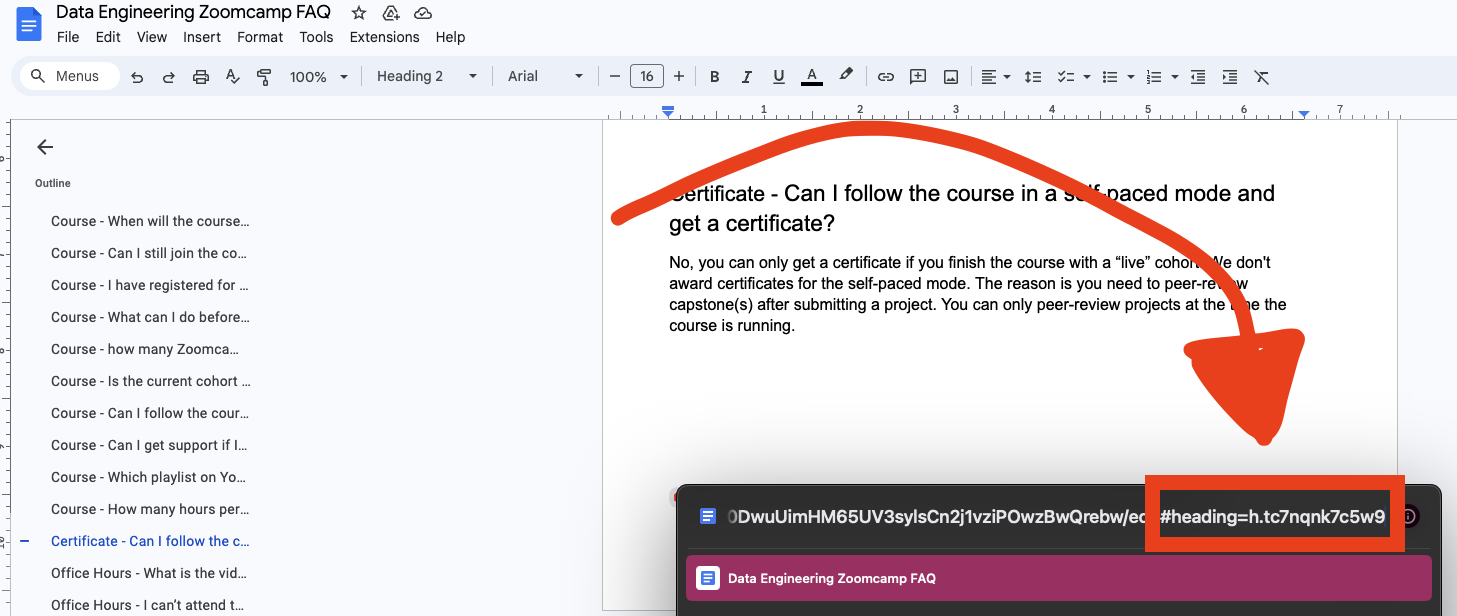
    - However, when we pull the data in using `requests.get(url)` we don't capture that header. If we use some google docs API, maybe we can???
- The next best option is to generate an `id` based on the contents of the actual question
    - While this is not immune to someone editing the question / response, that rarely happens as most of the time questions just get appended
    - So let's do that!
        - We'll combine the contents of the question, concatenate them and create an MD5 hash:

In [5]:
import hashlib

def generate_doc_id(doc):
    text = f"{doc['course']}|{doc['question']}|{doc['text'][:10]}"
    hash_object = hashlib.sha256(text.encode())
    hash_hex = hash_object.hexdigest()
    doc_id = hash_hex[:10]
    return doc_id

In [6]:
for doc in documents:
    doc['id'] = generate_doc_id(doc)

In [7]:
documents[4]

{'text': 'You can start by installing and setting up all the dependencies and requirements:\nGoogle cloud account\nGoogle Cloud SDK\nPython 3 (installed with Anaconda)\nTerraform\nGit\nLook over the prerequisites and syllabus to see if you are comfortable with these subjects.',
 'section': 'General course-related questions',
 'question': 'Course - What can I do before the course starts?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ffb90e86f4'}

- Let's check to see if our `id` are actually unique across all the records in the document

In [53]:
from collections import defaultdict

hashes = defaultdict(list)

for doc in documents:
    hashes[doc['id']].append(doc)

print(f"len(hashes): {len(hashes)} and len(documents): {len(documents)}")

len(hashes): 947 and len(documents): 948


In [54]:
for k, values in hashes.items():
    if len(values) > 1:
        print(k, len(values))

6712932b49 2


In [55]:
hashes['6712932b49']

[{'text': "They both do the same, it's just less typing from the script.\nAsked by Andrew Katoch, Added by Edidiong Esu",
  'section': '6. Decision Trees and Ensemble Learning',
  'question': 'Does it matter if we let the Python file create the server or if we run gunicorn directly?',
  'course': 'machine-learning-zoomcamp',
  'id': '6712932b49'},
 {'text': "They both do the same, it's just less typing from the script.",
  'section': '6. Decision Trees and Ensemble Learning',
  'question': 'Does it matter if we let the Python file create the server or if we run gunicorn directly?',
  'course': 'machine-learning-zoomcamp',
  'id': '6712932b49'}]

- Now that every record in our set has an id (except for one of them that's duplicated), we can do the part where we create five new questions that correspond to each answer in order to build a ground truth dataset
- Let's start by dumping the file we created above with ids into a .json file.

In [56]:
import json
with open('documents-with-ids.json', 'wt') as f:
    json.dump(documents, f, indent=2)

In [57]:
!head documents-with-ids.json

[
  {
    "text": "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  \u201cOffice Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon\u2019t forget to register in DataTalks.Club's Slack and join the channel.",
    "section": "General course-related questions",
    "question": "Course - When will the course start?",
    "course": "data-engineering-zoomcamp",
    "id": "6211ca3c99"
  },
  {
    "text": "GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites",


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


- Next, we want to create a prompt that will ask the LLM to emulate a student asking five questions for which the answer is provided in each record:

In [3]:
prompt_template = """

You emulate a student who is taking our course.
Formulate 5 questions this student might ask based on the FAQ record. The record should contain the answer to the questions, and the questions should be complete and not too short. If possible, use as few words from the FAQ record as possible.

The record:

section: {section}
question: {question}
answer: {text}

Provide the output in parsable JSON without using code blocks:

["question1", "question2", "question3", "question4", "question5"]

""".strip()

In [2]:
from openai import OpenAI
client = OpenAI()

- Let's now go through this step by step for one example record before iterating through all records to produce questions
    - Step 1: create a prompt based on a record in the document
    - Step 2: pass the prompt to OpenAI's completions API
    - Step 3: get the parsable json object back and parse it to see what five questions it created based on the record

In [9]:
prompt = prompt_template.format(**documents[4])
print(prompt)

You emulate a student who is taking our course.
Formulate 5 questions this student might ask based on the FAQ record. The record should contain the answer to the questions, and the questions should be complete and not too short. If possible, use as few words from the FAQ record as possible.

The record:

section: General course-related questions
question: Course - What can I do before the course starts?
answer: You can start by installing and setting up all the dependencies and requirements:
Google cloud account
Google Cloud SDK
Python 3 (installed with Anaconda)
Terraform
Git
Look over the prerequisites and syllabus to see if you are comfortable with these subjects.

Provide the output in parsable JSON without using code blocks:

["question1", "question2", "question3", "question4", "question5"]


In [12]:
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": prompt}
    ]
)

json_response = response.choices[0].message.content

print(json.loads(json_response))

['What should I do to prepare before the course starts?', 'How can I set up my environment before the course begins?', 'What tools and software do I need to install prior to starting the course?', 'Is there anything I need to check regarding my knowledge and comfort level before the course?', 'Which prerequisites and subjects should I review before the course starts?']


- Ok, so now we're ready to iterate over all records in the document and fill a dictionary called `results` that will look like this:
    - `{
        doc_id1: '[question1, question2, question3, question4, question5]',
        doc_id2: '[question1, question2, question3, question4, question5]',
        doc_idn: '[question1, question2, question3, question4, question5]'
    }`

In [17]:
def generate_questions(doc):
    prompt = prompt_template.format(**doc)
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    json_response = response.choices[0].message.content
    return json_response

In [13]:
from tqdm.auto import tqdm

results = {}

/Users/waleed/Documents/school/datatalksclub/llm-zoomcamp/llm-zoom/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
for doc in tqdm(documents):
    doc_id = doc['id']

    if doc_id in results:
        continue

    questions = generate_questions(doc)
    results[doc_id] = questions

100%|██████████| 948/948 [44:45<00:00,  2.83s/it]  


- Notice that in the `generate_questions` function, we didn't return a parsed json.
- What's odd is that in the youtube lecture, the questions the LLM returns were still strings, whereas in my case, it appears the LLM returned the questions in the form of a list
    - Which I assume means I don't have to parse them with `json.loads()`?
- We can check this by checking to see whether the value in the k:v pair of the results dictionary are all of type list:

In [30]:
first_value = type(next(iter(results.values())))

for doc_id, json_questions in results.items():
    if type(json_questions) != first_value:
        print(doc_id, type(json_questions))

7671536536 <class 'dict'>
894d8ce09c <class 'str'>
0472c382d4 <class 'str'>
42b4d84708 <class 'str'>
55dcff4cf4 <class 'str'>
29cfee5a3e <class 'str'>
ab25edb0b9 <class 'str'>
059eaeeb02 <class 'str'>
cc6c02553a <class 'str'>
dfa9da1a10 <class 'str'>
c2df75394c <class 'str'>
b9812f520f <class 'str'>
6029da3a58 <class 'str'>
b80a00d004 <class 'str'>
50210049e8 <class 'str'>
e2c864a9e0 <class 'str'>
f3f3929996 <class 'str'>
5114172eb3 <class 'str'>
50a4f1869c <class 'str'>
9dfbf0120a <class 'str'>
a97d507fb4 <class 'str'>
62f441fed0 <class 'str'>
cfe9851eed <class 'str'>
a58e31f4dd <class 'str'>
81c60bd243 <class 'str'>
a535c30e6a <class 'str'>
f0c3836a13 <class 'str'>
bdf8115220 <class 'str'>
7d9d119b28 <class 'str'>
974e5aab70 <class 'str'>
411da8cc5d <class 'str'>
ad319494ec <class 'str'>
757ba10dab <class 'str'>
4d43512131 <class 'str'>
fc8fb0e075 <class 'str'>
575746c8d0 <class 'str'>
f511bbce11 <class 'str'>
19dd528bbf <class 'str'>
abaec25cb1 <class 'str'>
7efa7a9ccf <class 'str'>

- Ok so it looks like I"m super wrong and a whole bunch of values in my results dictionary are in fact NOT lists
- So we'll need to use json.loads() after all

In [31]:
# parsed_results = {k: json.loads(v) for k, v in results.items()}

parsed_results = {}

for doc_id, json_questions in results.items():
    if isinstance(json_questions, str):
        parsed_results[doc_id] = json.loads(json_questions)
    else:
        parsed_results[doc_id] = json_questions



JSONDecodeError: Invalid \escape: line 3 column 81 (char 171)

- In the lesson video, the offending record is found and fixed before parsing. In my case, I'm just going to modify my parsing code above to just skip the entry that causes the issue and move on:
- Based on the below, there are three records that cause issues and I'm just going to ignore them!

In [49]:
parsed_results = {}

for doc_id, json_questions in results.items():
    try:
        if isinstance(json_questions, str):
            parsed_results[doc_id] = json.loads(json_questions)
        else:
            parsed_results[doc_id] = json_questions if isinstance(json_questions, list) else [json_questions]
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON for doc_id: {doc_id}")
        print(f"Problematic data: {json_questions}")
        continue

Error decoding JSON for doc_id: 50968e75d1
Problematic data: [
"What should I do if I receive an invalid mode error related to Docker mounting paths?",
"How can I resolve the Docker error response from the daemon regarding the path \Program Files\Git\var\lib\postgresql\data?",
"What are the correct mounting paths to use in Docker if the original one is invalid?",
"What is the solution for correcting the Docker mount path when encountering errors?",
"How do I adjust my Docker mounting path to avoid errors related to var/lib/postgresql/data?"
]
Error decoding JSON for doc_id: 4480b15330
Problematic data: ```json
[
  {
    "question": "How can I resolve the Docker-Compose error 'undefined volume' when working on Windows/WSL?",
    "answer": "If you wrote the docker-compose.yaml file exactly like the video, you might run into an error like this: dev service 'pgdatabase' refers to undefined volume dtc_postgres_volume_local: invalid compose project. In order to make it work, you need to incl

- Now that we've parsed our json output, we need to reassemble it into a dataframe that has the following columns: `[question, course, doc_id]`

In [53]:
first_value = type(next(iter(parsed_results.values())))

for doc_id, json_questions in parsed_results.items():
    if type(json_questions) != first_value:
        print(doc_id, json_questions)

50210049e8 {'questions': ['Which version of Python should I use for this course in 2024?', 'Is it better to use Python 3.9 for course consistency?', 'Can I use Python 3.10 or 3.11 for this course?', 'What is the recommended Python version for troubleshooting during this course?', 'Are there newer Python versions that work fine for this course?']}
9dfbf0120a {'questions': ['How can I open the Run command window on a Windows machine?', 'What steps should I follow to change registry values in Registry Editor?', "Where do I find the 'Autorun' registry value in the Registry Editor?", 'What is an alternative solution to changing registry values for solving the connection issue?', 'Where is the known_hosts file located on a Windows machine?']}
974e5aab70 {'question1': 'What is the best way to support and promote the course?', 'question2': 'How can I assist in enhancing the course materials?', 'question3': 'Are there any actions students can take to spread awareness of this course?', 'question

- Ok so it looks like what's happening is that the LLM added the key `question` in some cases to its response.
- I'm going to have to write some code to clean this up

In [58]:
parsed_results_fixed = {}

for doc_id, json_questions in parsed_results.items():
    if isinstance(json_questions, dict) and len(json_questions) == 1:
        parsed_results_fixed[doc_id] = next(iter(json_questions.values()))
    else:
        parsed_results_fixed[doc_id] = json_questions

In [59]:
results['50210049e8']

'{\n  "questions": [\n    "Which version of Python should I use for this course in 2024?",\n    "Is it better to use Python 3.9 for course consistency?",\n    "Can I use Python 3.10 or 3.11 for this course?",\n    "What is the recommended Python version for troubleshooting during this course?",\n    "Are there newer Python versions that work fine for this course?"\n  ]\n}'

In [60]:
parsed_results['50210049e8']

{'questions': ['Which version of Python should I use for this course in 2024?',
  'Is it better to use Python 3.9 for course consistency?',
  'Can I use Python 3.10 or 3.11 for this course?',
  'What is the recommended Python version for troubleshooting during this course?',
  'Are there newer Python versions that work fine for this course?']}

In [61]:
parsed_results_fixed['50210049e8']

['Which version of Python should I use for this course in 2024?',
 'Is it better to use Python 3.9 for course consistency?',
 'Can I use Python 3.10 or 3.11 for this course?',
 'What is the recommended Python version for troubleshooting during this course?',
 'Are there newer Python versions that work fine for this course?']

In [62]:
first_value = type(next(iter(parsed_results_fixed.values())))

for doc_id, json_questions in parsed_results_fixed.items():
    if type(json_questions) != first_value:
        print(doc_id, json_questions)

974e5aab70 {'question1': 'What is the best way to support and promote the course?', 'question2': 'How can I assist in enhancing the course materials?', 'question3': 'Are there any actions students can take to spread awareness of this course?', 'question4': 'If I have suggestions for improving the course, what should I do?', 'question5': 'What are some recommended ways to give back to the course community?'}
757ba10dab {'question1': 'Are there any recommended books or resources for the course?', 'question2': 'Where can I find additional materials for the course?', 'question3': 'Is there a list of suggested readings or resources for this class?', 'question4': 'Do you have any external resources that can supplement our learning?', 'question5': 'Can you point me to recommended books or other learning materials?'}
4d43512131 {'question1': 'Can I have more than one chance to submit a project in this course?', 'question2': 'What happens if I miss the first project deadline or fail the first s

- You know what, cleaning up all this data that came back from the LLM is going to take a lot of work
- I'm just going to give up and move on
    - If I really want to, I can just delete all the records that can't be easily parsed into a list format but I won't bother

- And now we're ready to start comparing our RAG performance against this ground truth dataset!

### 3.3.3 Evaluation of text retrieval techniques for RAG

- Now we're at the point where we can use our ground truth dataset from above to evaluate how good our semantic search engine using embeddings is working
    - NB.: Since my last few steps to generate a ground truth dataset didn't quite work I'm just going to import the one that was created in the lecture
    - I was getting really varied results from OpenAI for the questions, making it hard to clean and structure in a way that I can use in the evaluation step 
- So the way we're going to evaluate is by doing the following:

```python
for each question in ground_truth_dataset:
    ask the question
    return 5 "documents"
    check if the document_id in the ground_truth_dataset is one of the 5 documents returned
```

- Based on that, we can calculate two important evaluation scores:
    - The `Hit rate` which basically checks whether the document is in the set at all
    - The `Mean reciprical rank (MRR)` which checks how high in the ranking the document appears

- Ok let's go!

In [63]:
# let's first copy over the ground_truth_data.csv from the main DTC repo:
!wget https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-vector-search/eval/ground-truth-data.csv

--2024-07-18 10:02:58--  https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-vector-search/eval/ground-truth-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 504747 (493K) [text/plain]
Saving to: ‘ground-truth-data.csv’

ground-truth-data.c 100%[===================>] 492.92K  --.-KB/s    in 0.01s   

2024-07-18 10:02:58 (34.4 MB/s) - ‘ground-truth-data.csv’ saved [504747/504747]



In [113]:
## Now let's load the document-with-ids.json from DTC so that the doc_ids match

!wget https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-vector-search/eval/documents-with-ids.json

import json

with open('documents-with-ids.json', 'rt') as f:
    documents = json.load(f)

--2024-07-19 12:35:36--  https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-vector-search/eval/documents-with-ids.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 699257 (683K) [text/plain]
Saving to: ‘documents-with-ids.json.1’

documents-with-ids. 100%[===================>] 682.87K  --.-KB/s    in 0.02s   

2024-07-19 12:35:36 (37.0 MB/s) - ‘documents-with-ids.json.1’ saved [699257/699257]



JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [65]:
## Now let's set up our Elasticsearch indexes and load the documents. The steps are always:
### 1. Set up the elasticsearch client
### 2. Create the index settings which is basically defining the schema of the documents
###     Note that here, we're going to add the id we created to the index
### 3. Load the documents

## Step 1
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://192.168.50.49:9200')

In [70]:
## Step 2

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"}
        }
    }
}

index_name = "course-questions"


es_client.indices.delete(index=index_name, ignore_unavailable=True)
print(f"Index {index_name} deleted.")

es_client.indices.create(index=index_name, body=index_settings)
print(f"Index {index_name} created.")

Index course-questions deleted.
Index course-questions created.


In [97]:
## Step 3: Load the documents
from tqdm.auto import tqdm

for doc in tqdm(documents):
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

100%|██████████| 948/948 [00:04<00:00, 229.11it/s]


In [75]:
def elastic_search(query, course, num_results=5):
    search_query = {
        "size": num_results,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^3", "text", "section"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": course
                    }
                }
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)
    
    result_docs = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
    
    return result_docs

In [76]:
elastic_search(
    query = "I just discovered the course, can I still enroll?",
    course = "data-engineering-zoomcamp",
    num_results=5
)

[{'text': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.",
  'section': 'General course-related questions',
  'question': 'Course - Can I still join the course after the start date?',
  'course': 'data-engineering-zoomcamp',
  'id': 'bf432e9a88'},
 {'text': 'You can start by installing and setting up all the dependencies and requirements:\nGoogle cloud account\nGoogle Cloud SDK\nPython 3 (installed with Anaconda)\nTerraform\nGit\nLook over the prerequisites and syllabus to see if you are comfortable with these subjects.',
  'section': 'General course-related questions',
  'question': 'Course - What can I do before the course starts?',
  'course': 'data-engineering-zoomcamp',
  'id': 'ffb90e86f4'},
 {'text': 'Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it

- Now that we have the elastic search database running *without* embeddings (i.e. we're just doing a keyword search at this stage), we are ready to load in the ground truth dataset and iterate over the questions

In [77]:
import pandas as pd

df_ground_truth = pd.read_csv('ground-truth-data.csv')

ground_truth = df_ground_truth.to_dict(orient='records')

In [98]:
for q in ground_truth:
    print(f"The question we're testing is: {q['question']} and the document id is: {q['document']}")
    doc_id = q['document']
    results = elastic_search(query=q['question'], course=q['course'])
    relevance = [d['id'] == doc_id for d in results]
    break

relevance

The question we're testing is: When does the course begin? and the document id is: c02e79ef


[False, True, False, False, False]

In [99]:
results

[{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'section': 'General course-related questions',
  'question': 'Course - When will the course start?',
  'course': 'data-engineering-zoomcamp',
  'id': '6211ca3c99'},
 {'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin t

In [100]:
next((item for item in documents if item.get('id') == 'c02e79ef'), None)

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

- Ok so now we're ready to calculate the match sequence for all the questions in the ground truth set
    - Recall that because we created 5 questions for each answer, we now have close to 5000 records we can iterate over (instead of the original 1000)

In [103]:
match_array = []

for q in tqdm(ground_truth):
    doc_id = q['document']
    results = elastic_search(query=q['question'], course=q['course'])
    match = [d['id'] == doc_id for d in results]
    match_array.append(match)

100%|██████████| 4627/4627 [00:11<00:00, 403.53it/s]


In [104]:
match_array

[[False, True, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, True, False, False, False],
 [False, True, False, False, False],
 [False, True, False, False, False],
 [False, True, False, False, False],
 [False, True, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, True, False, False, False],
 [False, True, False, False, False],
 [False, True, False, False, False],
 [False, True, False, False, False],
 [False, True, False, False, False],
 [False, True, False, False, False],
 [],
 [],
 [],
 [],
 [],
 [False, True, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, True, False],
 [False, False, False, True, False],
 [

- Alright, so now that we have the data ordered, we can now calculate the performance metrics:
    - Hit rate:
    
        ```python
        for each record in match_array:
            if any item is True:
                add 1 to hit_rate counter
        
        return hit_rate counter divided by total number of entries in match_array
        ```
    - Mean reciprocal rank:
        - The implementation here gets fractional because we give weighting to where in the array a particular document appears
        - So if the document is the first item we add 1, but if it's the nth item, we add 1/n

        ```python
        for each record in match_array:
            for each item in record:
                if item is True:
                    add 1/(item index + 1) to mrr counter
        
        return mrr counter divided by total number of entries in match_array
        ```


In [105]:

def hit_rate(match_array):
    cnt = 0

    for line in match_array:
        if True in line:
            cnt += 1
    
    return cnt / len(match_array)

In [110]:
def mrr(match_array):
    score = 0.0

    for line in match_array:
        for i in range(len(line)):
            if line[i]:
                score += 1.0 / (i + 1)
                
    return score / len(match_array)

In [111]:
print(f"The hit rate is {hit_rate(match_array)} and the MRR is {mrr(match_array)}")

The hit rate is 0.6202723146747352 and the MRR is 0.28552697932425625


### 3.3.4 Evaluation vector retrieval
- In the above examples, we were still doing keyword or semantic search.
    - In summary, we were storing our documents as text with clearly identified `text` and `keyword` fields
    - We then incorporated the concept of a `ground truth` dataset in order to assess how well our Elasticsearch search engine works at retrieving the right documents corresponding to a text question that a user asks
- In this section, we combine what we did in the first section, namely vectorized search with the evaluation methodologies
    - This way, we can assess whether vector search does a better job than keyword/semantic search
- So let's begin. The first thing we need to do is create a new index in Elasticsearch specifying vector embeddings:

In [118]:
!wget https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-vector-search/eval/documents-with-ids.json

--2024-07-19 12:38:59--  https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-vector-search/eval/documents-with-ids.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 699257 (683K) [text/plain]
Saving to: ‘documents-with-ids.json’

documents-with-ids. 100%[===================>] 682.87K  --.-KB/s    in 0.02s   

2024-07-19 12:38:59 (29.4 MB/s) - ‘documents-with-ids.json’ saved [699257/699257]



In [119]:
import json

with open('documents-with-ids.json', 'rt') as f:
    documents = json.load(f)

In [120]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://192.168.50.49:9200')

- In the previous section, we used `all-mpnet-base-v2` to create model encodings
- You can find the full list of SBERT's original models [here](https://sbert.net/docs/sentence_transformer/pretrained_models.html)
    - For the purpose of this next section, we're going to pick the model with the highest performance and speed: `multi-qa-MiniLM-L6-cos-v1`
    - You can find some sample code for how to use this model on its HuggingFace card [here](https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1)
    
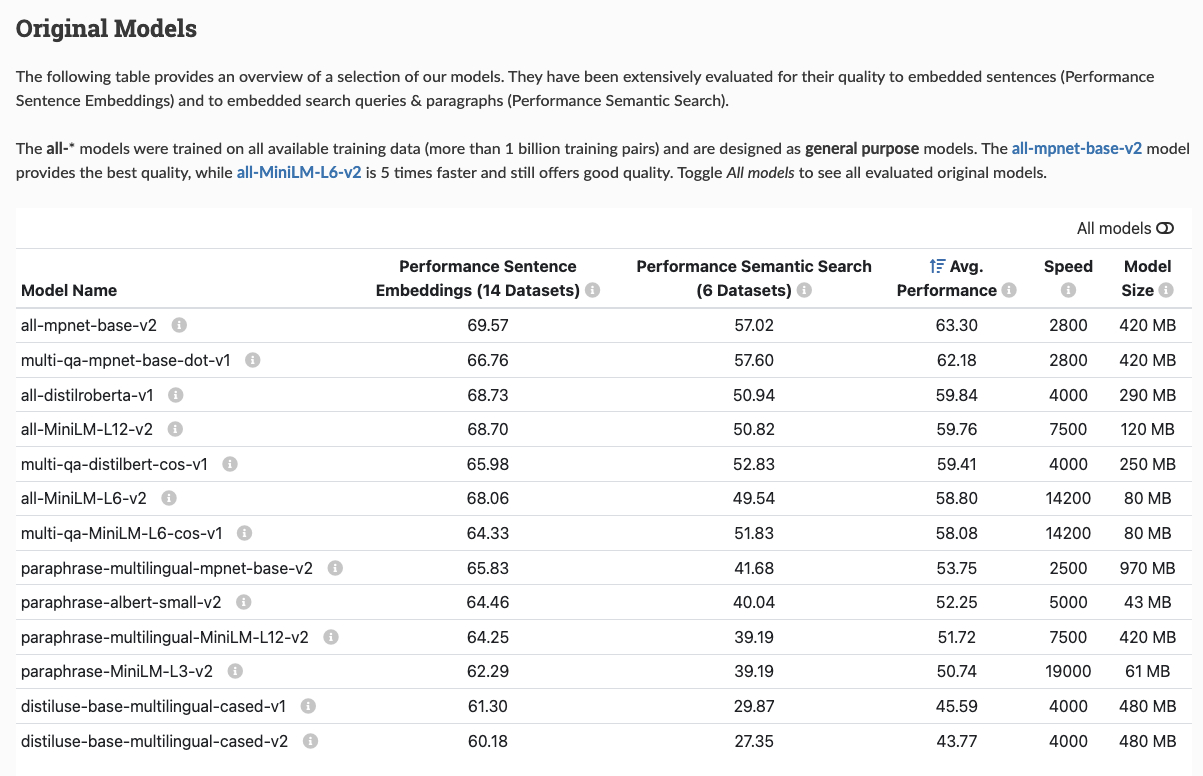

In [123]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained model
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [124]:
# Encode sentences to get embeddings
sentences = ["How are you?", "What is your name?", "Hello! How do you do?"]
embeddings = model.encode(sentences)

# Compute similarity between the first sentence and the others
similarities = util.dot_score(embeddings[0], embeddings[1:])[0].cpu().tolist()

print(similarities)

[0.358455091714859, 0.46344706416130066]


- At this point, we need to create embeddings for three things:
    - The questions
    - The answers
    - The combination of questions and answers
- The way we add embeddings, if you recall from the previous lessons, to Elasticsearch's index is like this:
    ```python
    "text_embedding": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"}
    ```
    - For our new model, we'll need to change the dimensionality to match
        - See below, but each embedding has a dimension of size 384

In [129]:
len(embeddings[0])

384

In [131]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
            # the answer vector:
            "text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },

        }
    }
}

index_name = "course-questions"

if es_client.indices.exists(index=index_name):
    es_client.indices.delete(index=index_name)
    print(f"Index {index_name} deleted.")

es_client.indices.create(index=index_name, body=index_settings)
print(f"Index {index_name} created.")

Index course-questions deleted.
Index course-questions created.


- Now we need to iterate over all the records in the document and encode the question, the answer and the question+answer combo
- And then we can index them all in our Elasticsearch database

In [132]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    question_text = f"{question} {text}"

    doc['question_vector'] = model.encode(question)
    doc['text_vector'] = model.encode(text)
    doc['question_text_vector'] = model.encode(question_text)

100%|██████████| 948/948 [02:28<00:00,  6.37it/s]


In [133]:
for doc in tqdm(documents):
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

100%|██████████| 948/948 [00:06<00:00, 139.32it/s]


- Now we can construct our search query, just like we did in the first section:

In [136]:
user_query = "I just discovered the course. Can I still joint it?" 
v_user_query = model.encode(user_query)

# Pass the embedded version of the question to the Elasticsearch search function
knn_query = {
    "field": "question_vector",
    "query_vector": v_user_query,
    "k": 5,
    "num_candidates": 10000,
}

## Add a filter to the search
filter_query = {"match": {"course": "data-engineering-zoomcamp"}}

res = es_client.search(index=index_name,
                       query = filter_query,
                       knn=knn_query, 
                       source=["text", "section", "question", "course", "id"],
                       size=3,
                       explain=True)

res["hits"]["hits"]

[{'_shard': '[course-questions][0]',
  '_node': 'lxwBTO3-R-e0G28Pi0OWpQ',
  '_index': 'course-questions',
  '_id': 'vlYizJABj0afZ5DYluGe',
  '_score': 1.5826765,
  '_source': {'question': 'Course - Can I follow the course after it finishes?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it finishes.\nYou can also continue looking at the homeworks and continue preparing for the next cohort. I guess you can also start working on your final capstone project.',
   'id': 'a482086d'},
  '_explanation': {'value': 1.5826765,
   'description': 'sum of:',
   'details': [{'value': 0.80376256,
     'description': 'within top k documents',
     'details': []},
    {'value': 0.778914,
     'description': 'weight(course:data-engineering-zoomcamp in 7) [PerFieldSimilarity], result of:',
     'details': [{'value': 0.778914,
       

- Let's put this into a function so we can use it to evaluate like before

In [137]:
def elastic_search_knn(user_query, query_vector, course_filter):
    # Define the KNN query
    knn_query = {
        "field": query_vector,
        "query_vector": user_query,
        "k": 5,
        "num_candidates": 10000
    }

    # Define the filter query
    filter_query = {
        "match": {
            "course": course_filter
        }
    }

    # Execute the KNN search
    res = es_client.search(index=index_name,
                           query = filter_query,
                           knn=knn_query, 
                           source=["text", "section", "question", "course", "id"])

    result_docs = []
    
    # Extract the relevant documents from the search results
    result_docs = [hit['_source'] for hit in res['hits']['hits']]

    return result_docs

In [141]:
elastic_search_knn("question_vector", v_user_query, "data-engineering-zoomcamp")

[{'question': 'Course - Can I follow the course after it finishes?',
  'course': 'data-engineering-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it finishes.\nYou can also continue looking at the homeworks and continue preparing for the next cohort. I guess you can also start working on your final capstone project.',
  'id': 'a482086d'},
 {'question': 'Course - Can I still join the course after the start date?',
  'course': 'data-engineering-zoomcamp',
  'section': 'General course-related questions',
  'text': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.",
  'id': '7842b56a'},
 {'question': 'Course - Can I get support if I take the course in the self-paced mode?',
  'course': 'data-en

- Now we're ready to evaluate. Let's create a function to evaluate how well our search function works
- To do that, we need to iterate over all the records in our ground_truth dataset, grab the question, vectorize it and then pass it through our `elastic_search_knn` function
- Then we take the results of that and we calculate the hit rate and the mrr

In [151]:
def question_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn("question_vector", v_q, course)    

In [152]:
def evaluate(ground_truth, search_function):
    match_array = []

    for q in tqdm(ground_truth):
        doc_id = q['document']
        results = search_function(q)
        match = [d['id'] == doc_id for d in results]
        match_array.append(match)

    return {
        "hit_rate": hit_rate(match_array),
        "mrr": mrr(match_array)
    }

In [153]:
import pandas as pd
ground_truth = pd.read_csv('ground-truth-data.csv').to_dict(orient='records')
ground_truth[0]

{'question': 'When does the course begin?',
 'course': 'data-engineering-zoomcamp',
 'document': 'c02e79ef'}

In [154]:
evaluate(ground_truth, question_vector_knn)

100%|██████████| 4627/4627 [01:53<00:00, 40.74it/s]


{'hit_rate': 0.7406526907283337, 'mrr': 0.654936260939071}

- The previous hit rate and mrr were:
    - `The hit rate is 0.6202723146747352 and the MRR is 0.28552697932425625`
    - But it took 11.4 seconds to run, whereas this took almost 2 minutes to run
    - Does the performance improvement justify the switch from a keyword search to a vectorized search?

In [155]:
def text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn("text_vector", v_q, course)  

In [156]:
evaluate(ground_truth, text_vector_knn)

100%|██████████| 4627/4627 [01:52<00:00, 41.28it/s]


{'hit_rate': 0.7968446077371947, 'mrr': 0.6952315772501649}

In [157]:
def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn("question_text_vector", v_q, course)  

In [158]:
evaluate(ground_truth, question_text_vector_knn)

100%|██████████| 4627/4627 [01:51<00:00, 41.48it/s]


{'hit_rate': 0.8958288307758807, 'mrr': 0.816419926518263}

- The performance has improved dramatically when you combine question and text into one vector